In [1]:
# load partial_linear from the same subfolder
from functions import *
import warnings
warnings.simplefilter("ignore", RuntimeWarning)
import numpy as np
import pandas as pd
import time
# from missingpy import MissForest
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import norm
from hyperopt import tpe, hp, STATUS_OK, Trials
from hyperopt import fmin as hyperopt_fmin
import time
import matplotlib.pyplot as plt


df = pd.read_csv("iwpc_prob.csv", index_col=0)
delta_class = np.array(df['Outcome']).reshape(-1,1)
T = np.array(df['Therapeutic Dose of Warfarin']).reshape(-1,1)
Y_prob = np.array(df['soft_labels']).reshape(-1,1)
Y = np.log((Y_prob + .000005) / (1.00005 - Y_prob))
X = df.drop(columns=['Therapeutic Dose of Warfarin',
                    'Outcome',
                    'soft_labels'
                    ])
column_names = X.columns
X = X.values
### code to get  X, Y, T, soft_labels_series
n,p = X.shape
Z = np.concatenate([X, T, Y, Y_prob, delta_class], axis=1)
Z_train, Z_test = train_test_split(Z, test_size=0.05, random_state=42)
X_train = Z_train[:, :p]
T_train = Z_train[:, p]
Y_train = Z_train[:, p + 1]
Y_prob_train = Z_train[:, p + 2]
delta_train = Z_train[:, p + 3]

X_test = Z_test[:, :p]
T_test = Z_test[:, p]
Y_test = Z_test[:, p + 1]
Y_prob_test = Z_test[:, p + 2]
delta_test = Z_test[:, p + 3]


In [2]:
column_names

Index(['Age', 'Height (cm)', 'Weight (kg)', 'Indication for Warfarin',
       'Diabetes', 'CHF/Cardiomyopathy', 'Valve Replacement', 'Aspirin',
       'Amiodarone_Cordarone', 'Current Smoker', 'Use of Statins',
       'Use of Enzyme Inducers', 'Use of Antibiotics', 'Gender_male',
       'Race_Black or African American', 'Race_Unknown', 'Race_White',
       'CYP2C9_*1/*2', 'CYP2C9_*1/*3', 'CYP2C9_other', 'VKORC1 -1639_A/G',
       'VKORC1 -1639_G/G', 'VKORC1 497_G/T', 'VKORC1 497_T/T',
       'VKORC1 1173_C/T', 'VKORC1 1173_T/T', 'VKORC1 1542_C/G',
       'VKORC1 1542_G/G', 'VKORC1 3730_A/G', 'VKORC1 3730_G/G'],
      dtype='object')

Precision: 0.6463
Recall: 0.6974
F1 Score: 0.6709


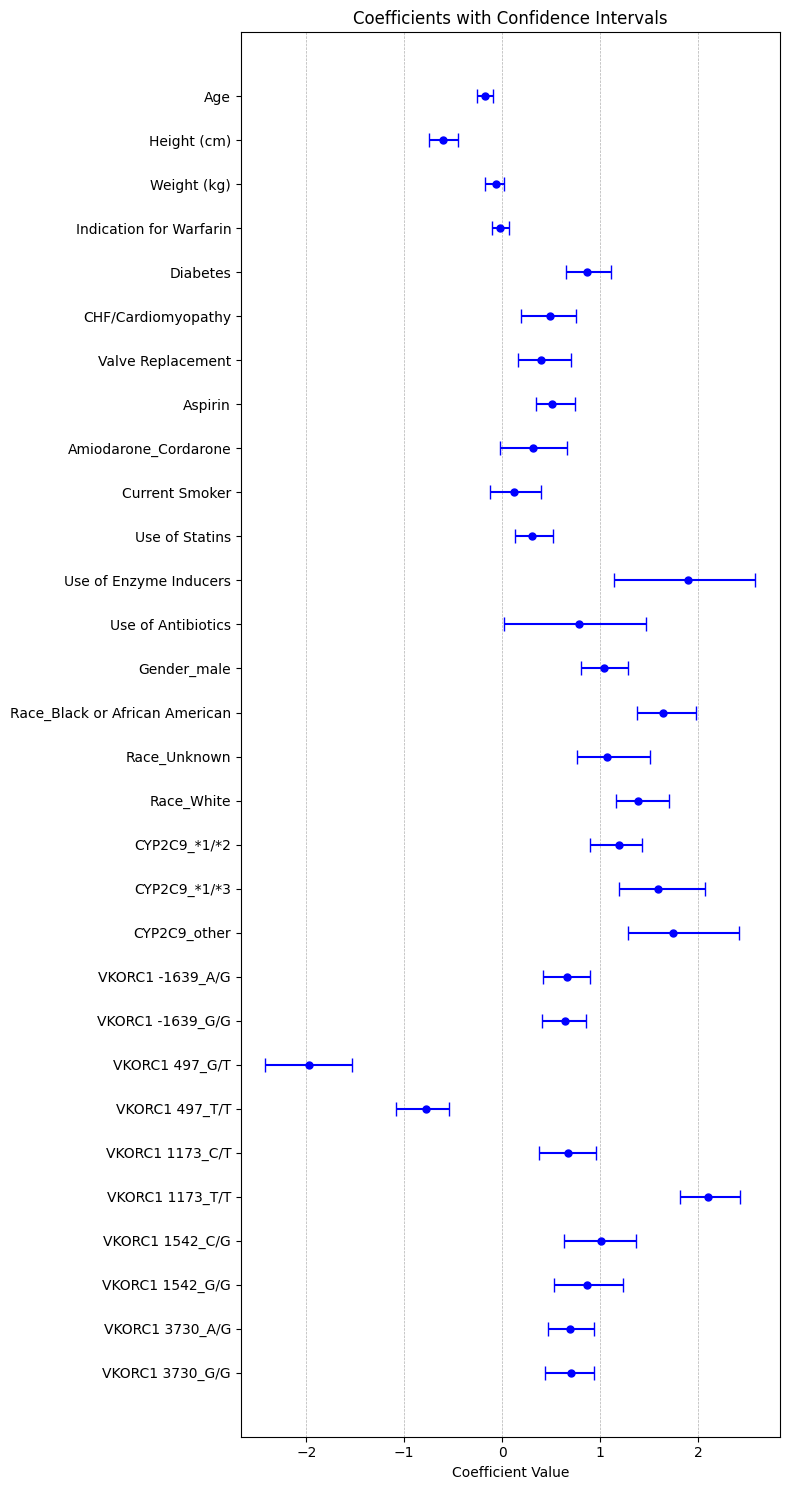

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import numpy as np
def plot_params_conf(params, conf, colnames):
    fig, ax = plt.subplots(figsize=(8, len(colnames) * 0.5))
    ax.errorbar(params, range(len(params)),
                xerr=(params - conf[:, 0], conf[:, 1] - params),
                fmt='o', markersize=5, capsize=5, color='blue')
    ax.set_yticks(range(len(params)))
    ax.set_yticklabels(colnames)
    ax.set_xlabel('Coefficient Value')
    ax.set_title('Coefficients with Confidence Intervals')
    ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
    ax.invert_yaxis()  # This will reverse the y-axis direction
    plt.tight_layout()
    plt.show()

def bootstrap_conf_interval(X, y, model_class, weights=None, n_bootstrap=100):
    bootstrap_coefs = []

    for _ in range(n_bootstrap):
        X_resampled, y_resampled = resample(X, y)
        if weights is not None:
            weights_resampled = resample(weights)
            model = model_class().fit(X_resampled, y_resampled, sample_weight=weights_resampled)
        else:
            model = model_class().fit(X_resampled, y_resampled)
        bootstrap_coefs.append(model.coef_[0])

    bootstrap_coefs = np.array(bootstrap_coefs)
    lower_bound = np.percentile(bootstrap_coefs, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_coefs, 97.5, axis=0)
    return np.vstack((lower_bound, upper_bound)).T


# For the unweighted logistic regression
lr = LogisticRegression().fit(X_train, delta_train)
lr_params = lr.coef_[0]
lr_conf = bootstrap_conf_interval(X_train, delta_train, LogisticRegression)
probs_test = lr.predict(X_test)
predicted_test = (probs_test > 0.5).astype(int)
precision = precision_score(delta_test, predicted_test)
recall = recall_score(delta_test, predicted_test)
f1 = f1_score(delta_test, predicted_test)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

plot_params_conf(lr_params, lr_conf, column_names)


W/ Treatment LR Precision: 0.6506
W/ Treatment LR Recall: 0.7105
W/ Treatment LR F1 Score: 0.6792


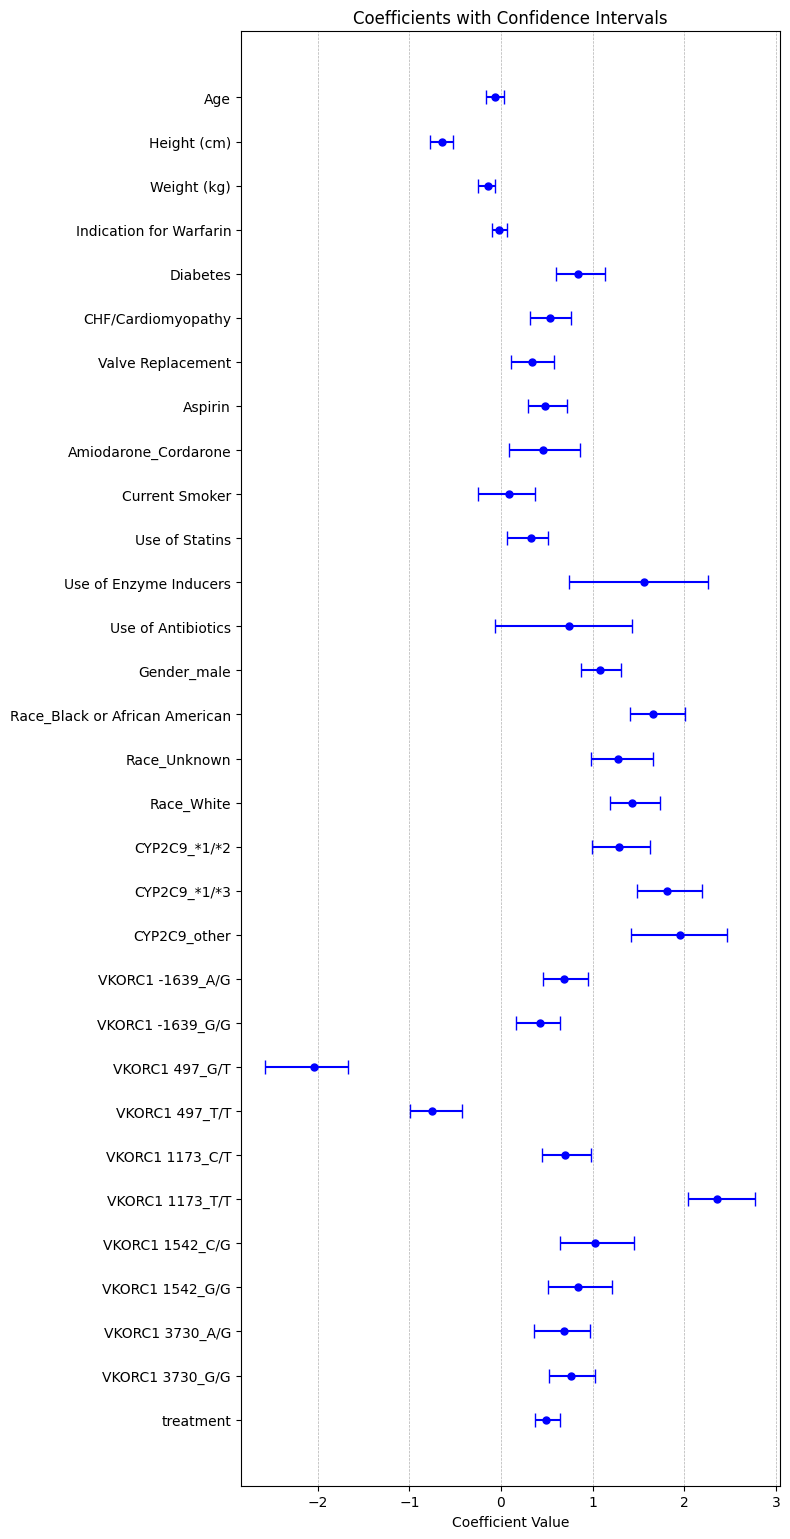

In [4]:
# Concatenate T_train to X_train and T_test to X_test
X_train_combined = np.column_stack((X_train, T_train))
X_test_combined = np.column_stack((X_test, T_test))

# Fit logistic regression
lr_treat = LogisticRegression().fit(X_train_combined, delta_train)
lr_treat_params = lr_treat.coef_[0]
lr_treat_conf = bootstrap_conf_interval(X_train_combined, delta_train, LogisticRegression)
# print(lr_treat_res.summary())

# Predict probabilities and classify
probs_test = lr_treat.predict(X_test_combined)
predicted_test = (probs_test > 0.5).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(delta_test, predicted_test)
recall = recall_score(delta_test, predicted_test)
f1 = f1_score(delta_test, predicted_test)

print(f'W/ Treatment LR Precision: {precision:.4f}')
print(f'W/ Treatment LR Recall: {recall:.4f}')
print(f'W/ Treatment LR F1 Score: {f1:.4f}')
plot_params_conf(lr_treat_params, lr_treat_conf, column_names.tolist()+['treatment'])

In [5]:
import json
with open("data.json", "r") as file:
    data = json.load(file)

# Convert lists back to NumPy arrays
XI_opt = np.array(data["mean_XI_opt"])
BETA_opt = np.array(data["mean_BETA_opt"])
conf_XI_opt = np.array(data["conf_interval_XI_opt"]).T
conf_BETA_opt = np.array(data["conf_interval_BETA_opt"]).T

W/ Treatment LR Precision: 0.6506
W/ Treatment LR Recall: 0.7105
W/ Treatment LR F1 Score: 0.6792


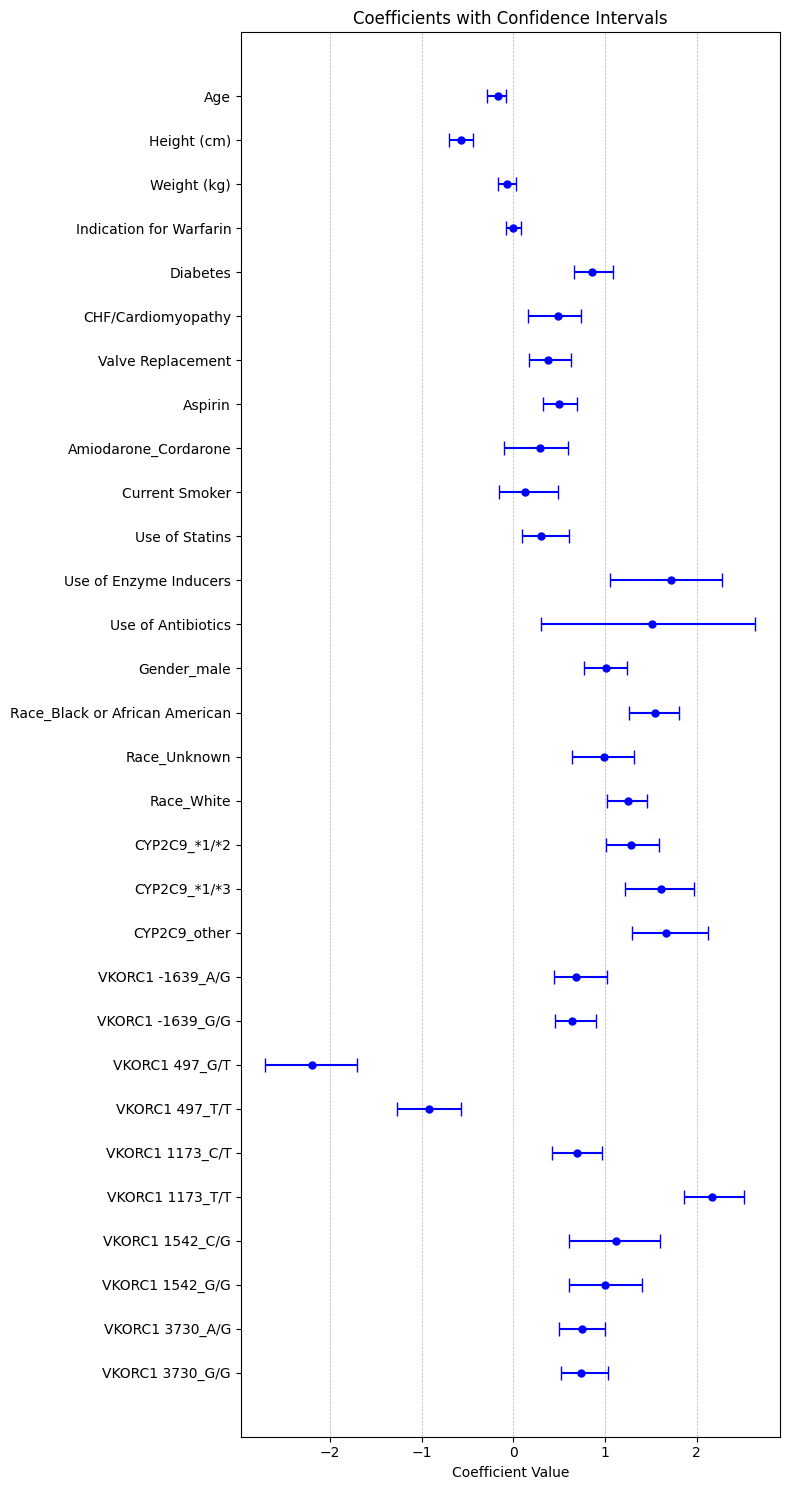

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample

# Fit the LDA model on the original dataset
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, delta_train)
n_bootstrap = 100
bootstrap_coefs = []


for _ in range(n_bootstrap):
    # Resample data with replacement
    X_resampled, y_resampled = resample(X_train, delta_train)
    
    # Fit LDA on the resampled data
    lda_boot = LinearDiscriminantAnalysis()
    lda_boot.fit(X_resampled, y_resampled)
    
    # Store the coefficients
    bootstrap_coefs.append(lda_boot.coef_[0])

# Convert to array for easier indexing
bootstrap_coefs = np.array(bootstrap_coefs)

# Calculate 95% confidence intervals
lower_bound = np.percentile(bootstrap_coefs, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_coefs, 97.5, axis=0)
confidence_intervals = np.vstack((lower_bound, upper_bound)).T
lda_params = lda.coef_[0]
lda_conf = confidence_intervals


# Calculate precision, recall, and F1 score
precision = precision_score(delta_test, predicted_test)
recall = recall_score(delta_test, predicted_test)
f1 = f1_score(delta_test, predicted_test)

print(f'W/ Treatment LR Precision: {precision:.4f}')
print(f'W/ Treatment LR Recall: {recall:.4f}')
print(f'W/ Treatment LR F1 Score: {f1:.4f}')
plot_params_conf(lda_params, lda_conf, column_names)


Precision: 0.6500
Recall: 0.6842
F1 Score: 0.6667
W/ Treatment LR Precision: 0.6500
W/ Treatment LR Recall: 0.6842
W/ Treatment LR F1 Score: 0.6667


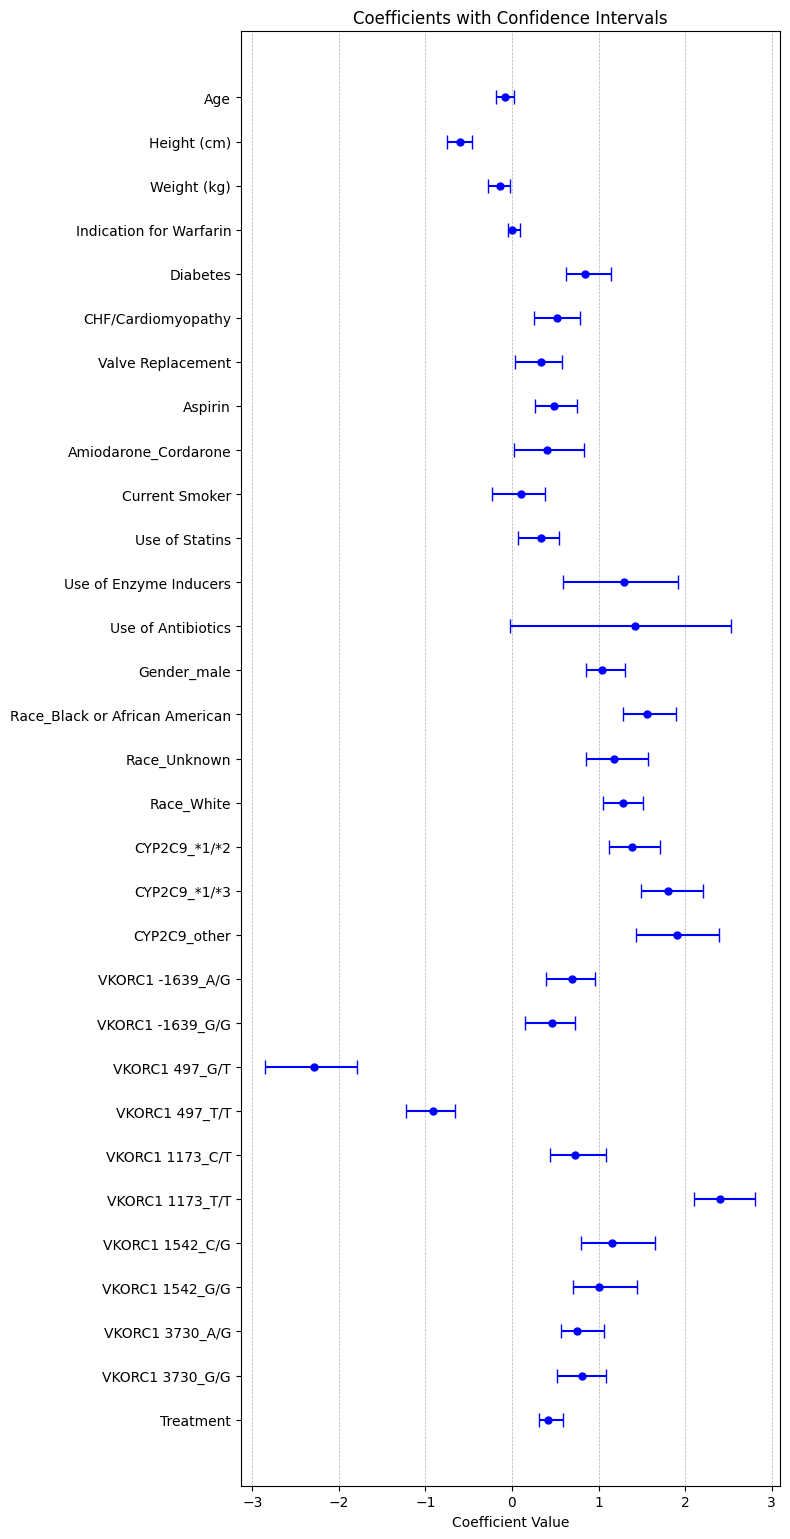

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample

X_train_combined = np.column_stack((X_train, T_train))
X_test_combined = np.column_stack((X_test, T_test))
# Fit the LDA model on the original dataset
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_combined, delta_train)
n_bootstrap = 100
bootstrap_coefs = []

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probs_test = sigmoid(lda.decision_function(X_test_combined))
predicted_test = (probs_test > 0.5).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(delta_test, predicted_test)
recall = recall_score(delta_test, predicted_test)
f1 = f1_score(delta_test, predicted_test)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

for _ in range(n_bootstrap):
    # Resample data with replacement
    X_resampled, y_resampled = resample(X_train_combined, delta_train)
    
    # Fit LDA on the resampled data
    lda_boot = LinearDiscriminantAnalysis()
    lda_boot.fit(X_resampled, y_resampled)
    
    # Store the coefficients
    bootstrap_coefs.append(lda_boot.coef_[0])

# Convert to array for easier indexing
bootstrap_coefs = np.array(bootstrap_coefs)

# Calculate 95% confidence intervals
lower_bound = np.percentile(bootstrap_coefs, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_coefs, 97.5, axis=0)
confidence_intervals = np.vstack((lower_bound, upper_bound)).T
lda_treat_params = lda.coef_[0]
lda_treat_conf = confidence_intervals
# Calculate precision, recall, and F1 score
precision = precision_score(delta_test, predicted_test)
recall = recall_score(delta_test, predicted_test)
f1 = f1_score(delta_test, predicted_test)

print(f'W/ Treatment LR Precision: {precision:.4f}')
print(f'W/ Treatment LR Recall: {recall:.4f}')
print(f'W/ Treatment LR F1 Score: {f1:.4f}')
plot_params_conf(lda_treat_params, lda_treat_conf, column_names.tolist()+["Treatment"])

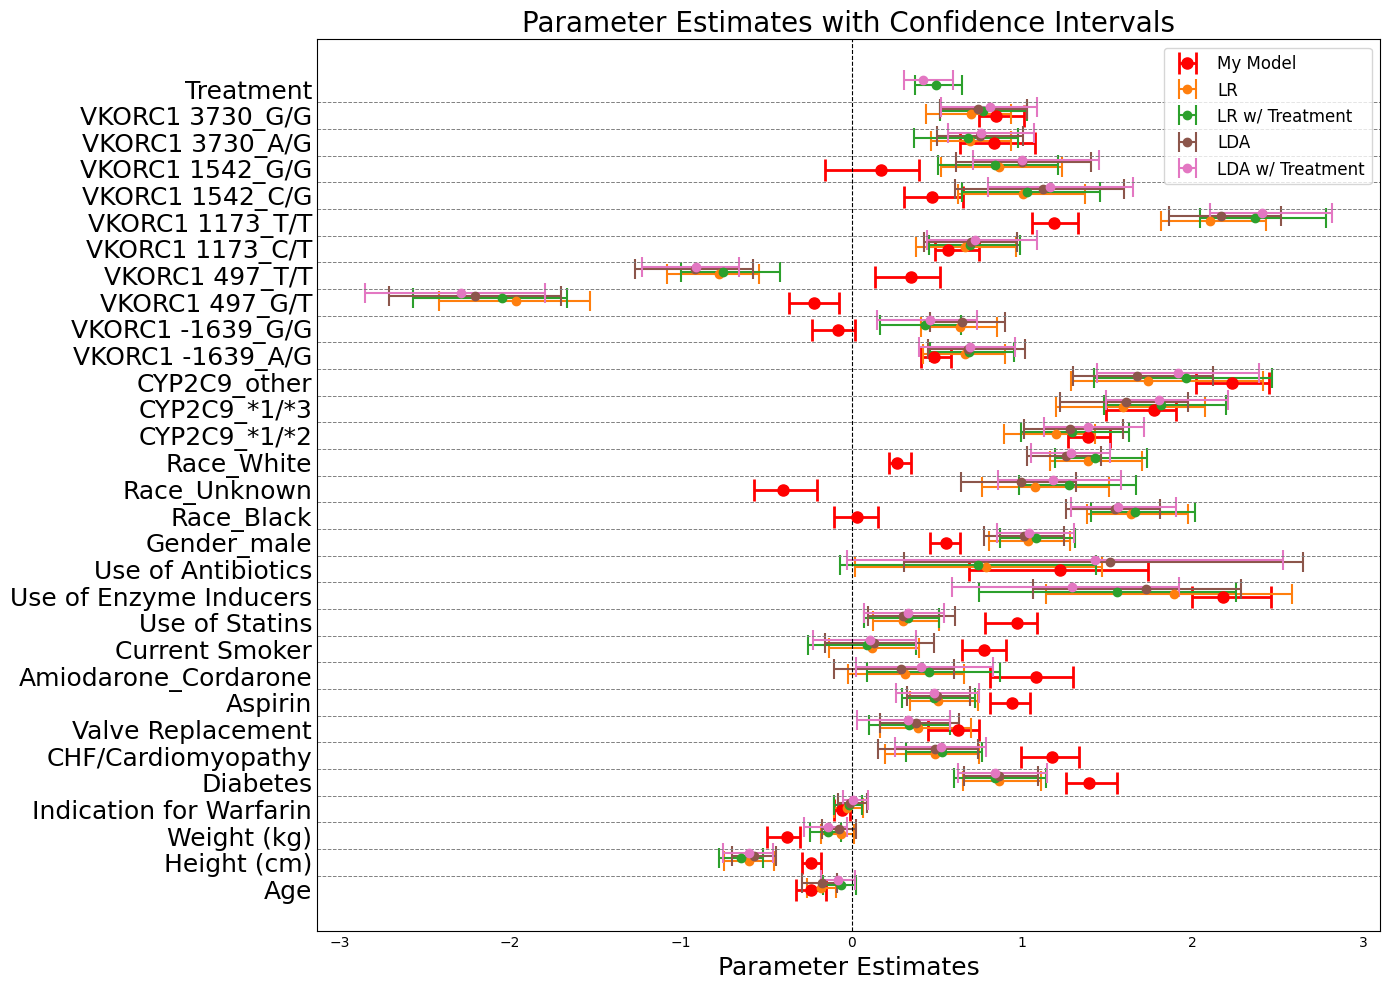

In [8]:
import matplotlib.pyplot as plt

column_names = ['Age', 'Height (cm)', 'Weight (kg)',
       'Indication for Warfarin', 'Diabetes',
       'CHF/Cardiomyopathy', 'Valve Replacement',
       'Aspirin', 'Amiodarone_Cordarone', 'Current Smoker', 'Use of Statins',
       'Use of Enzyme Inducers', 'Use of Antibiotics', 'Gender_male',
       'Race_Black', 'Race_Unknown',
       'Race_White', 'CYP2C9_*1/*2', 'CYP2C9_*1/*3',
       'CYP2C9_other', 'VKORC1 -1639_A/G',
       'VKORC1 -1639_G/G', 'VKORC1 497_G/T',
       'VKORC1 497_T/T', 'VKORC1 1173_C/T',
       'VKORC1 1173_T/T', 'VKORC1 1542_C/G',
       'VKORC1 1542_G/G', 'VKORC1 3730_A/G',
       'VKORC1 3730_G/G']
extended_column_names = column_names + ["Treatment"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# Store data for each model in a list
models_data = [
    {"params": BETA_opt, "conf": conf_BETA_opt, "label": "My Model", "color": colors[0]},
    {"params": lr_params, "conf": lr_conf, "label": "LR", "color": colors[1]},
    {"params": lr_treat_params, "conf": lr_treat_conf, "label": "LR w/ Treatment", "color": colors[2]},
    {"params": lda_params, "conf": lda_conf, "label": "LDA", "color": colors[4]},
    {"params": lda_treat_params, "conf": lda_treat_conf, "label": "LDA w/ Treatment", "color": colors[5]} 
    ]

# Compute the total number of parameters
total_params = len(extended_column_names)

# Set up figure and axis
fig, ax = plt.subplots(figsize=(14, 10))

# Adjust gap based on the number of models
gap_multiplier = len(models_data)
gap = 15 * gap_multiplier  

# Base y-positions
y_positions_base = [i * gap for i in range(total_params)]

for idx, model_data in enumerate(models_data):
    offset = ((idx - (gap_multiplier - 1) / 2) * 7)
    y_positions = [y + offset + 45 for y in y_positions_base]
    if model_data["label"] == "My Model":
        marker_size = 8  # larger marker size
        line_width = 2
        cap_size = 8
        model_color = 'red'  # standout color for "My Model"
    else:
        marker_size = 6
        line_width = 1.5
        cap_size = 7
        model_color = model_data["color"]

    ax.errorbar(model_data["params"], y_positions[:len(model_data["params"])], 
                xerr=[model_data["params"] - model_data["conf"][:, 0], model_data["conf"][:, 1] - model_data["params"]], 
                fmt='o', label=model_data["label"], color=model_color, markersize=marker_size, 
                capsize=cap_size, elinewidth=line_width, capthick=line_width)
# Adjust the y-axis labels to be centered for each set of models
y_label_positions = [y_positions_base[i] + gap/2 - 2 for i in range(total_params)]
ax.set_yticks(y_label_positions)
ax.set_yticklabels(extended_column_names, fontsize=18, rotation=0, ha='right')

# Add gridlines for y-axis at boundaries of the lanes
lane_boundaries = [y_positions_base[i] + gap - 4 for i in range(total_params - 1)]
for boundary in lane_boundaries:
    ax.axhline(y=boundary, color='gray', linestyle='--', linewidth=0.7)

# Hide the ticks
ax.tick_params(axis='both', which='both', length=0)
ax.yaxis.grid(False)
ax.xaxis.grid(False)
# Set other plot properties
ax.set_xlabel('Parameter Estimates', fontsize=18)
ax.set_title('Parameter Estimates with Confidence Intervals', fontsize=20)
ax.legend(loc='best', fontsize=12)
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
# Ensure the layout is clean
plt.tight_layout()
plt.show()


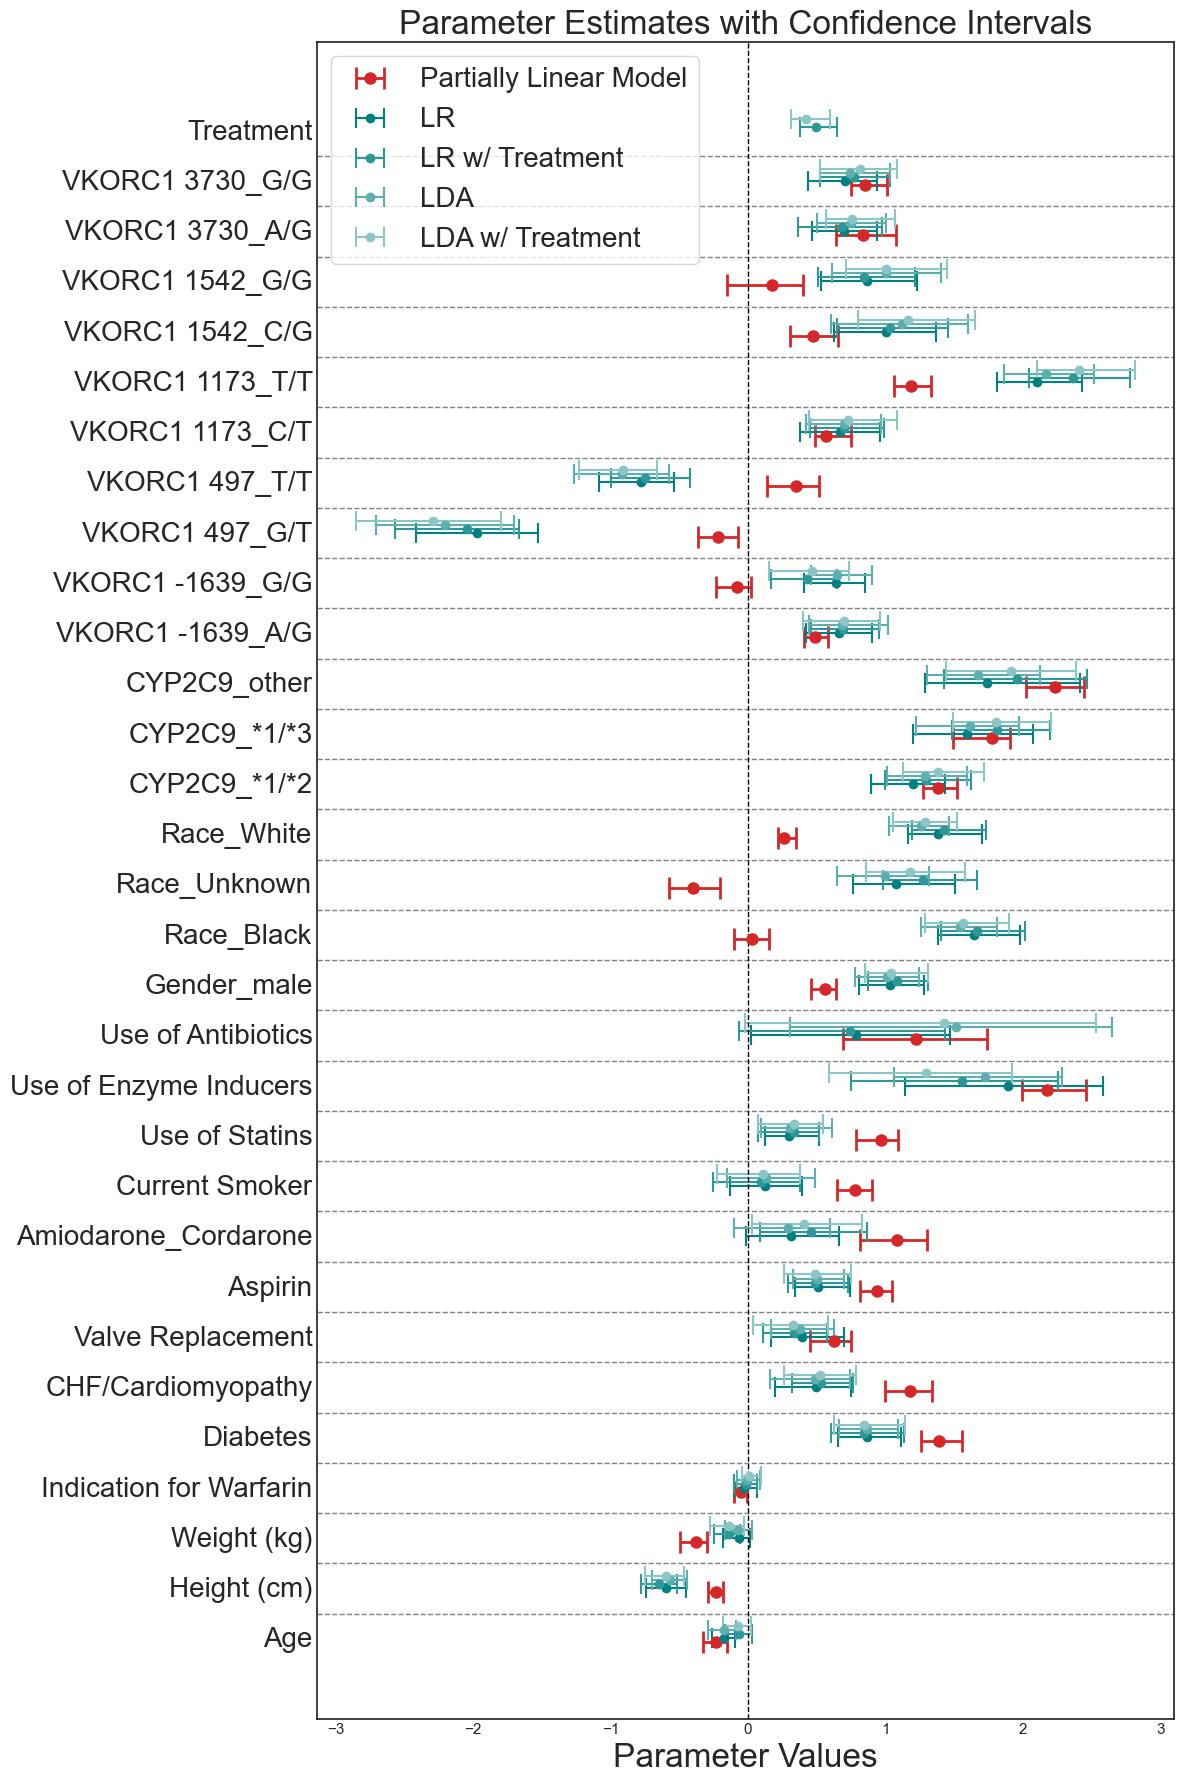

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plot
sns.set(style="white")

# Define a more subtle color palette for other models
other_models_colors = sns.light_palette("teal", n_colors=6,reverse=True)
# Bright, distinctive color for "Partially Linear Model"
my_model_color = '#d62728'  # A bright red color

# Adjusting the column names to include 'Treatment'
extended_column_names = column_names + ["Treatment"]

# Store data for each model in a list
models_data = [
    {"params": BETA_opt, "conf": conf_BETA_opt, "label": "Partially Linear Model", "color": my_model_color},
    {"params": lr_params, "conf": lr_conf, "label": "LR", "color": other_models_colors[0]},
    {"params": lr_treat_params, "conf": lr_treat_conf, "label": "LR w/ Treatment", "color": other_models_colors[1]},
    {"params": lda_params, "conf": lda_conf, "label": "LDA", "color": other_models_colors[2]},
    {"params": lda_treat_params, "conf": lda_treat_conf, "label": "LDA w/ Treatment", "color": other_models_colors[3]}
]

# Compute the total number of parameters
total_params = len(extended_column_names)

# Set up figure and axis
fig, ax = plt.subplots(figsize=(12, 18))

# Adjust gap based on the number of models
gap_multiplier = len(models_data)
gap = 15 * gap_multiplier  

# Base y-positions
y_positions_base = [i * gap for i in range(total_params)]

# Plot data for each model
for idx, model_data in enumerate(models_data):
    offset = ((idx - (gap_multiplier - 1) / 2) * 6)
    y_positions = [y + offset + 40 for y in y_positions_base]

    # Customizing markers for "Partially Linear Model"
    marker_size = 8 if model_data["label"] == "Partially Linear Model" else 6
    line_width = 2 if model_data["label"] == "Partially Linear Model" else 1.5
    cap_size = 8 if model_data["label"] == "Partially Linear Model" else 7

    ax.errorbar(model_data["params"], y_positions[:len(model_data["params"])], 
                xerr=[model_data["params"] - model_data["conf"][:, 0], model_data["conf"][:, 1] - model_data["params"]], 
                fmt='o', label=model_data["label"], color=model_data["color"], markersize=marker_size, 
                capsize=cap_size, elinewidth=line_width, capthick=line_width)

# Adjust the y-axis labels to be centered for each set of models
y_label_positions = [y_positions_base[i] + gap/2 - 2 for i in range(total_params)]
# ax.set_xticks(font = 12)
ax.set_yticks(y_label_positions)
ax.set_yticklabels(extended_column_names, fontsize=20, rotation=0, ha='right')

# Add gridlines for y-axis at boundaries of the lanes
for boundary in lane_boundaries:
    ax.axhline(y=boundary, color='gray', linestyle='--', linewidth=1.0)

# Hide the ticks
ax.tick_params(axis='both', which='both', length=0)
ax.yaxis.grid(False)
ax.xaxis.grid(False)

# Set other plot properties
ax.set_xlabel('Parameter Values', fontsize=24)
ax.set_title('Parameter Estimates with Confidence Intervals', fontsize=24)
ax.legend(loc='best', fontsize=20)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.0)

# Ensure the layout is clean
plt.tight_layout()
plt.savefig('diag_comp.png', dpi=300)
plt.show()
